# Hard magnet workflow

## Introduction

- In this notebook we explore hard magnet properties such as Hc as function of material and temperature.
- We query databases to get temperature-dependent inputs for micromagnetic simulations from DFT and spin dynamics simulations
- We run hysteresis simulations and compute derived quantities.

Requirements:
- Software: `mammos` Python package, `esys-escript`
- Basic understanding of [mammos-units](https://mammos-project.github.io/mammos/examples/mammos-units/quickstart.html) and [mammos-entity](https://mammos-project.github.io/mammos/examples/mammos-entity/quickstart.html)

In [1]:
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps
import math

import mammos_analysis
import mammos_dft
import mammos_spindynamics
import mammos_mumag
import mammos_entity as me
import mammos_units as u

In [2]:
# Allow convenient conversions between A/m and T
u.set_enabled_equivalencies(u.magnetic_flux_field());

## DFT data: magnetization and anisotropy at zero Kelvin
The first step loads spontaneous magnetization `Ms_0` and the uniaxial anisotropy constant `K1_0` from a database of DFT calculations (at T=0K).

We can use the `print_info` flag to trigger printing of crystallographic information.

In [3]:
results_dft = mammos_dft.db.get_micromagnetic_properties("Nd2Fe14B", print_info=True)

Found material in database.

Chemical Formula: Nd2Fe14B
Space group name: P42/mnm
Space group number: 136
Cell length a: 8.78 Angstrom
Cell length b: 8.78 Angstrom
Cell length c: 12.12 Angstrom
Cell angle alpha: 90.0 deg
Cell angle beta: 90.0 deg
Cell angle gamma: 90.0 deg
Cell volume: 933.42 Angstrom3
ICSD_label: 
OQMD_label:

In [4]:
results_dft

MicromagneticProperties(Ms_0=SpontaneousMagnetization(value=1280000.0, unit=A / m), K1_0=UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3))

In [5]:
results_dft.Ms_0

SpontaneousMagnetization(value=1280000.0, unit=A / m)

In [6]:
results_dft.K1_0

UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3)

## Temperature-dependent magnetization data from spindynamics database lookup
In the second step we use a spin dynamics calculation database to load data for the temperature-dependent magnetization.

In [7]:
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetization("Nd2Fe14B")

We can visualize the pre-computed data using `.plot`.

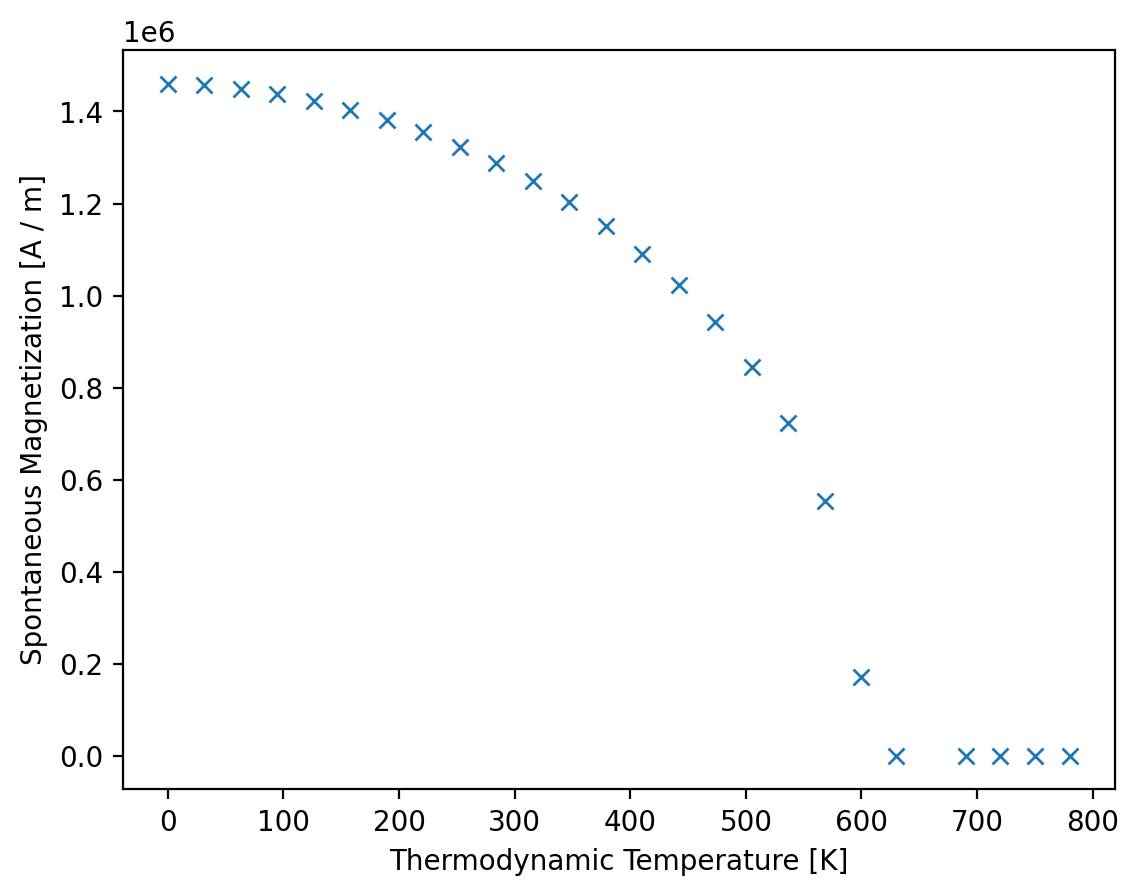

In [8]:
results_spindynamics.plot();

We can access `T` and `Ms` and get `mammos_entities.Entity` objects:

In [9]:
results_spindynamics.T

ThermodynamicTemperature(value=
[  0.          31.57894737  63.15789474  94.73684211 126.31578947
 157.89473684 189.47368421 221.05263158 252.63157895 284.21052632
 315.78947368 347.36842105 378.94736842 410.52631579 442.10526316
 473.68421053 505.26315789 536.84210526 568.42105263 600.
 630.         690.         720.         750.         780.        ],
 unit=K)

In [10]:
results_spindynamics.Ms

SpontaneousMagnetization(value=
[1460000.         1456985.36046193 1449449.93657199 1437972.77253639
 1422736.58364638 1403779.39648225 1381044.11152378 1354391.97626968
 1323600.99407897 1288353.67899904 1248213.31769096 1202584.11677895
 1150645.20320241 1091237.80552561 1022660.54963577  942263.95974459
  845538.33920183  723617.755767    553555.21471405  171781.14820705
       0.               0.               0.               0.
       0.        ],
 unit=A / m)

We can get also the data in the form of a `pandas.DataFrame`, which only contains the values in SI units:

In [11]:
results_spindynamics.dataframe.head()

,T,Ms
0,0.000000,1.460000e+06
1,31.578947,1.456985e+06
2,63.157895,1.449450e+06
3,94.736842,1.437973e+06
4,126.315789,1.422737e+06


## Calculate micromagnetic intrinsic properties using Kuz'min formula

- We use Kuzmin equations to compute Ms(T), A(T), K1(T)
- Kuz’min, M.D., Skokov, K.P., Diop, L.B. et al. Exchange stiffness of ferromagnets. Eur. Phys. J. Plus 135, 301 (2020). https://doi.org/10.1140/epjp/s13360-020-00294-y
- Additional details about inputs and outputs are available in the [API reference](https://mammos-project.github.io/mammos/_autosummary/mammos_analysis.kuzmin.html#mammos_analysis.kuzmin.kuzmin_formula)

In [12]:
results_kuzmin = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.K1_0,
)

The `plot` method of the returned object can be used to visualize temperature-dependence of all three quantities. The temperature range matches that of the fit data:

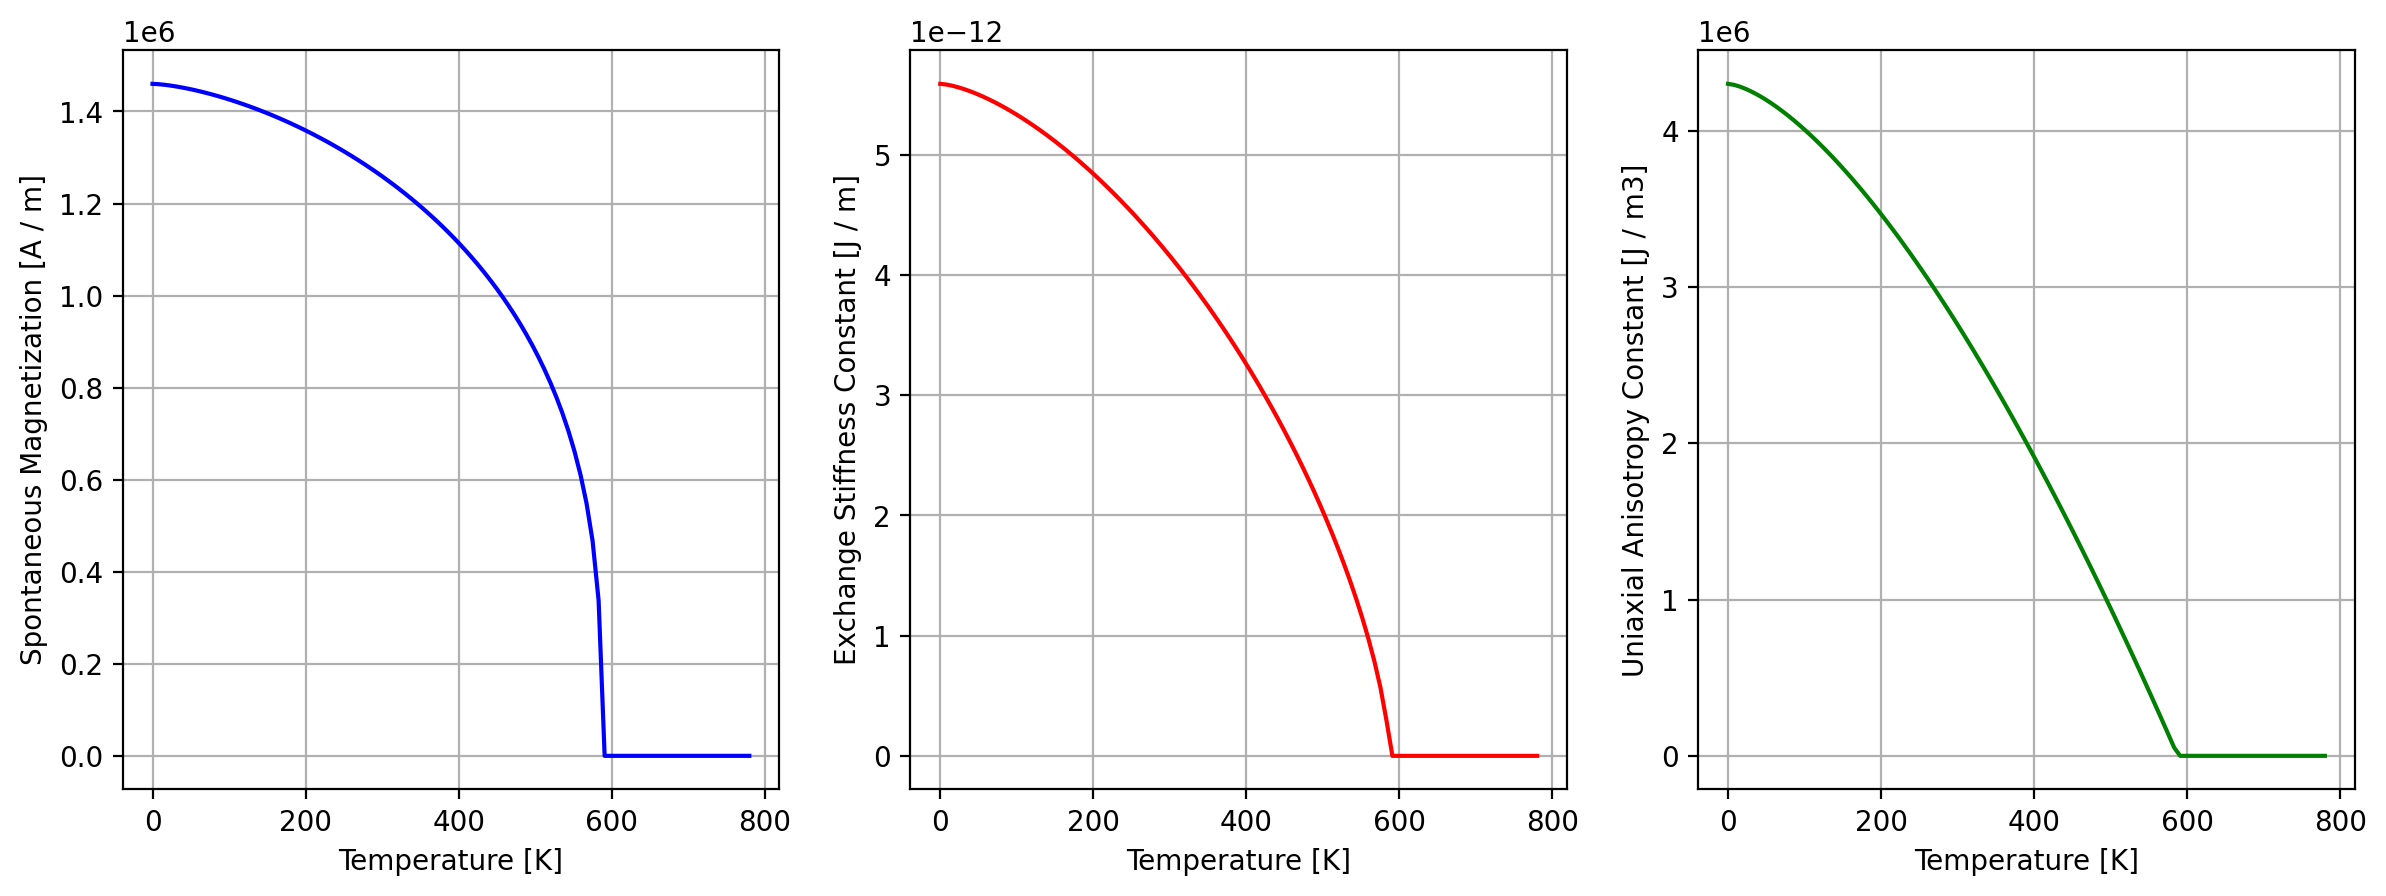

In [13]:
results_kuzmin.plot();

In [14]:
results_kuzmin

KuzminResult(Ms=Ms(T), A=A(T), Tc=ThermodynamicTemperature(value=587.7781199945458, unit=K), s=<Quantity 0.96482643>, K1=K1(T))

- The attributes `Ms`, `A` and `K1` provide fit results as function of temperature. They each have a `plot` method.
- `Tc` is the fitted Curie temperature.
- `s` is a fit parameter in the Kuzmin equation.

To visually assess the accuracy of the fit, we can combine the `plot` methods of `results_kuzmin.Ms` and `results_spindynamics`:

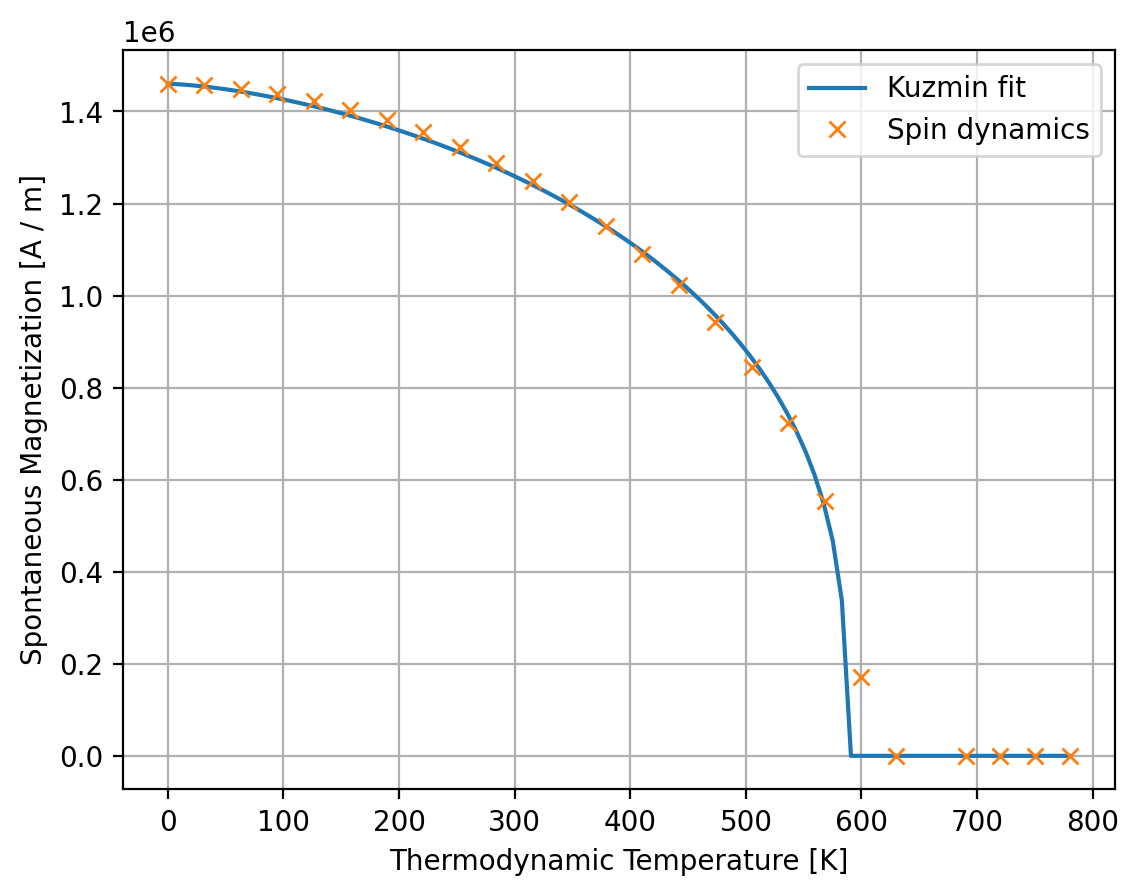

In [15]:
ax = results_kuzmin.Ms.plot(label="Kuzmin fit")
results_spindynamics.plot(ax=ax, label="Spin dynamics");

To get inputs for the micromagnetic simulation at a specific temperature we call the three attributes `Ms`, `A` and `K1`. We can pass a `mammos_entity.Entity`, an `astropy.units.Quantity` or a number:

In [16]:
temperature = me.T(300)
temperature

ThermodynamicTemperature(value=300.0, unit=K)

In [17]:
results_kuzmin.Ms(temperature)  # Evaluation with Entity

SpontaneousMagnetization(value=1259264.6948937078, unit=A / m)

In [18]:
results_kuzmin.A(300 * u.K)  # Evaluation with Quantity

ExchangeStiffnessConstant(value=4.158634560339533e-12, unit=J / m)

In [19]:
results_kuzmin.K1(300)  # Evaluation with number

UniaxialAnisotropyConstant(value=2759058.8934449223, unit=J / m3)

## Run micromagnetic simulation to compute hysteresis loop
- We now compute a hysteresis loop (using a finite-element micromagnetic simulation) with the material parameters we have obtained.
- We simulate a 20x20x20 nm cube for which a pre-defined mesh is available.
- Additional documentation of this step is available [this notebook](https://mammos-project.github.io/mammos/examples/mammos-mumag/quickstart.html).

In [20]:
results_hysteresis = mammos_mumag.hysteresis.run(
    mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
    Ms=results_kuzmin.Ms(temperature),
    A=results_kuzmin.A(temperature),
    K1=results_kuzmin.K1(temperature),
    hstart=(7 * u.T).to(u.A / u.m),
    hfinal=(-7 * u.T).to(u.A / u.m),
    hnsteps=30,
)

The returned `results_hysteresis` object provides a `plot` method to visualize the computed data. `mammos_mumag.hysteresis` only computes half a hysteresis loop, going from `hstart` to `hfinal`. To show a full loop this function mirrors the computed data and plots it twice:

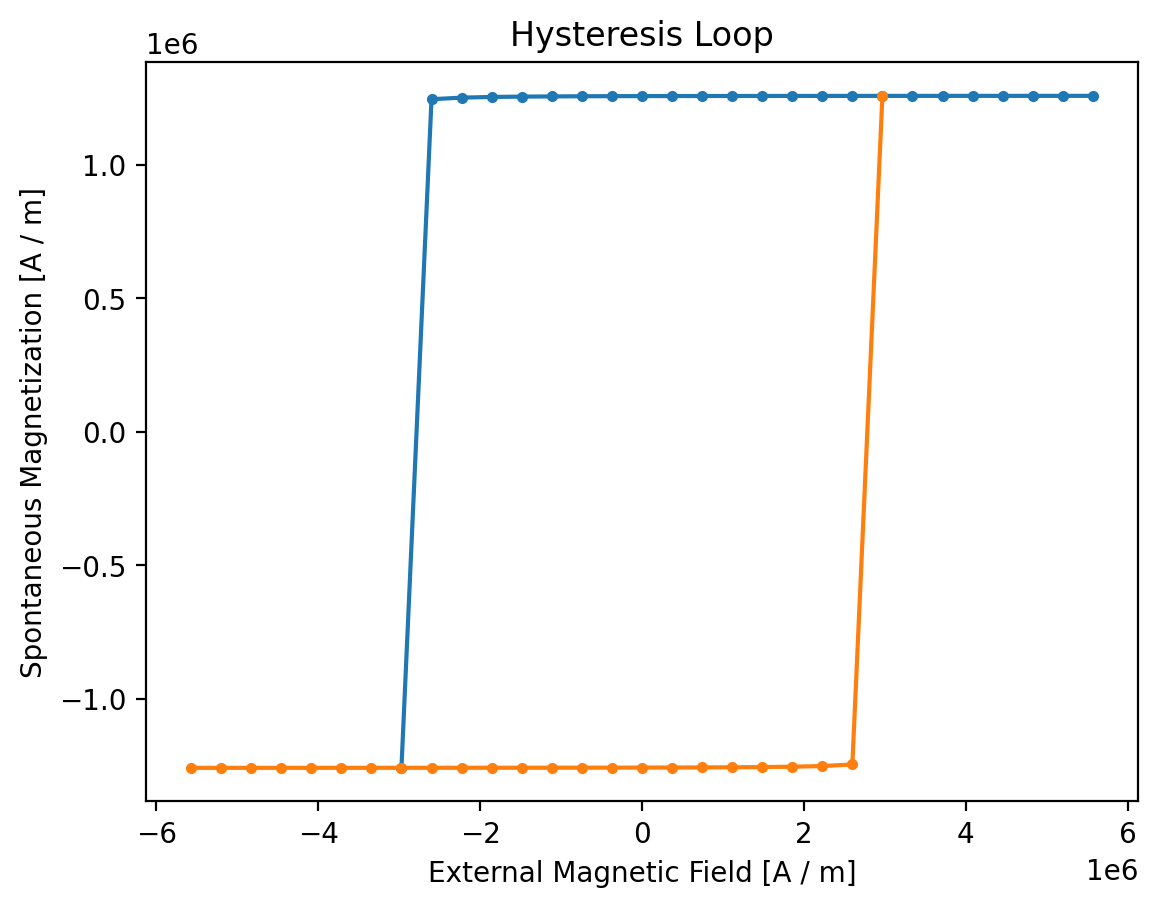

In [21]:
results_hysteresis.plot(marker=".");  # blue: simulation output, orange: mirrored data

The result object provides access to `H` and `M`:

In [22]:
results_hysteresis.H

ExternalMagneticField(value=
[ 5.57042301e+06  5.19906147e+06  4.82769994e+06  4.45633840e+06
  4.08497687e+06  3.71361534e+06  3.34225380e+06  2.97089227e+06
  2.59953074e+06  2.22816920e+06  1.85680767e+06  1.48544613e+06
  1.11408460e+06  7.42723067e+05  3.71361534e+05 -1.32523112e-09
 -3.71361534e+05 -7.42723067e+05 -1.11408460e+06 -1.48544613e+06
 -1.85680767e+06 -2.22816920e+06 -2.59953074e+06 -2.97089227e+06],
 unit=A / m)

In [23]:
results_hysteresis.M

SpontaneousMagnetization(value=
[ 1259072.54948691  1259056.52001863  1259038.39279785  1259017.78447148
  1258994.21963159  1258967.10304789  1258935.6814279   1258898.99010979
  1258855.77746115  1258804.39570145  1258742.63975825  1258667.50387095
  1258574.80385497  1258458.57271322  1258310.05901017  1258115.99273815
  1257855.45160588  1257493.74581818  1256969.7955139   1256166.91835032
  1254835.5848787   1252339.46477503  1246373.65097544 -1258898.99373608],
 unit=A / m)

The `dataframe` property generates a dataframe in the SI units.

In [24]:
results_hysteresis.dataframe.head()

,configuration_type,H,M,energy_density
0,1,5.570423e+06,1.259073e+06,-1.126330e+07
1,1,5.199061e+06,1.259057e+06,-1.067573e+07
2,1,4.827700e+06,1.259038e+06,-1.008818e+07
3,1,4.456338e+06,1.259018e+06,-9.500630e+06
4,1,4.084977e+06,1.258994e+06,-8.913094e+06


We can generate a table in alternate units:

In [25]:
df = pd.DataFrame(
    {
        "mu0_H": results_hysteresis.H.to(u.T),
        "J": results_hysteresis.M.to(u.T),
    },
)
df.head()

,mu0_H,J
0,7.000000,1.582197
1,6.533333,1.582177
2,6.066667,1.582154
3,5.600000,1.582128
4,5.133333,1.582099


### Plotting of magnetization configurations

Simulation stores specific magnetization field configurations:

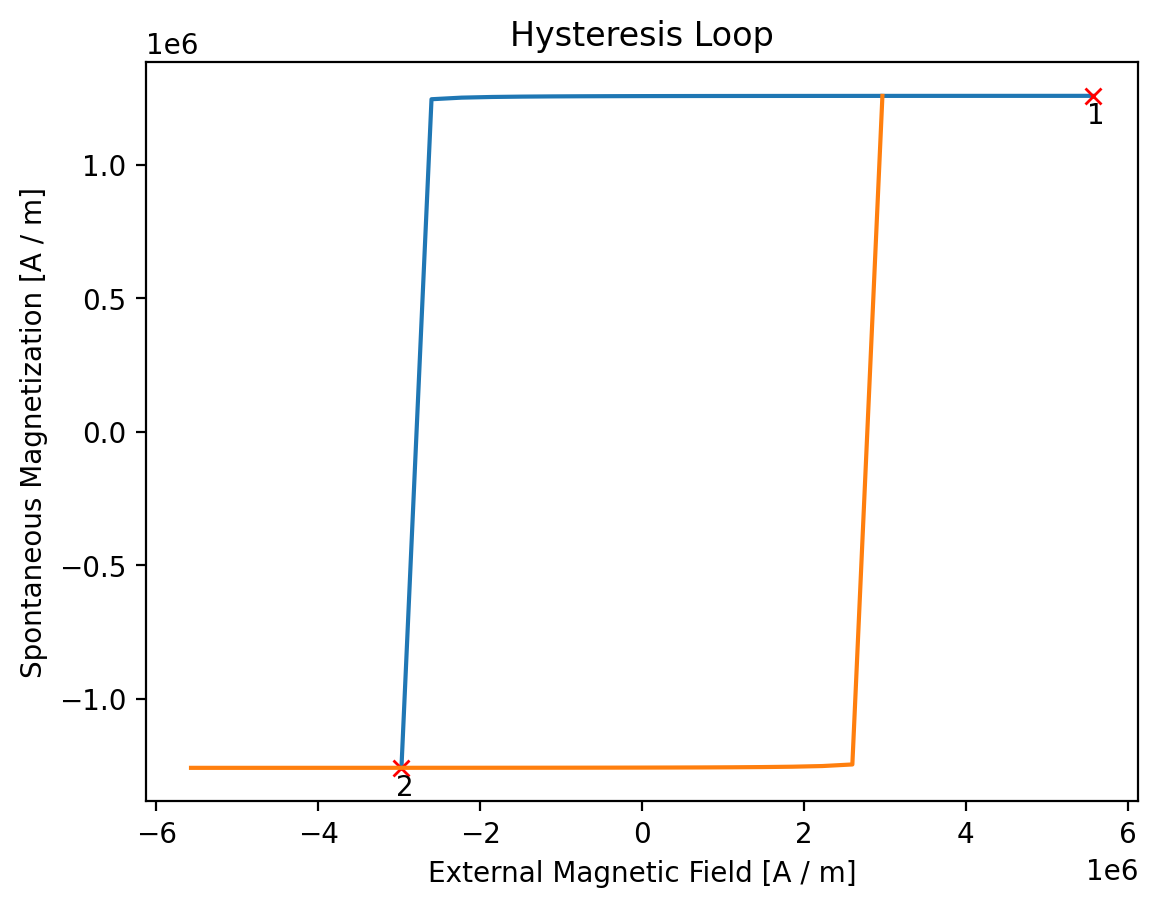

In [26]:
results_hysteresis.plot(configuration_marks=True);

In [27]:
results_hysteresis.configurations

{1: PosixPath('/home/mlang/repos/mammos/mammos/docs/source/examples/workflows/hystloop/hystloop_0001.vtu'),
 2: PosixPath('/home/mlang/repos/mammos/mammos/docs/source/examples/workflows/hystloop/hystloop_0002.vtu')}

In [28]:
results_hysteresis.plot_configuration(1);

Widget(value='<iframe src="http://localhost:44915/index.html?ui=P_0x7f7783b0ab90_0&reconnect=auto" class="pyvi…

## Analyze hysteresis loop
We can extract extrinsic properties with the `extrinsic_properties` function from the `mammos_analysis` package:

In [29]:
extrinsic_properties = mammos_analysis.hysteresis.extrinsic_properties(
    results_hysteresis.H,
    results_hysteresis.M,
    demagnetisation_coefficient=1 / 3,
)

In [30]:
extrinsic_properties.Hc

CoercivityHcExternal(value=2784283.174390393, unit=A / m)

In [31]:
extrinsic_properties.Mr

Remanence(value=1258115.9927381477, unit=A / m)

In [32]:
extrinsic_properties.BHmax

MaximumEnergyProduct(value=218030.75811610813, unit=J / m3)

We can combine the `results_hysteresis.plot` method with some custom code to show Hc and Mr in the hysteresis plot:

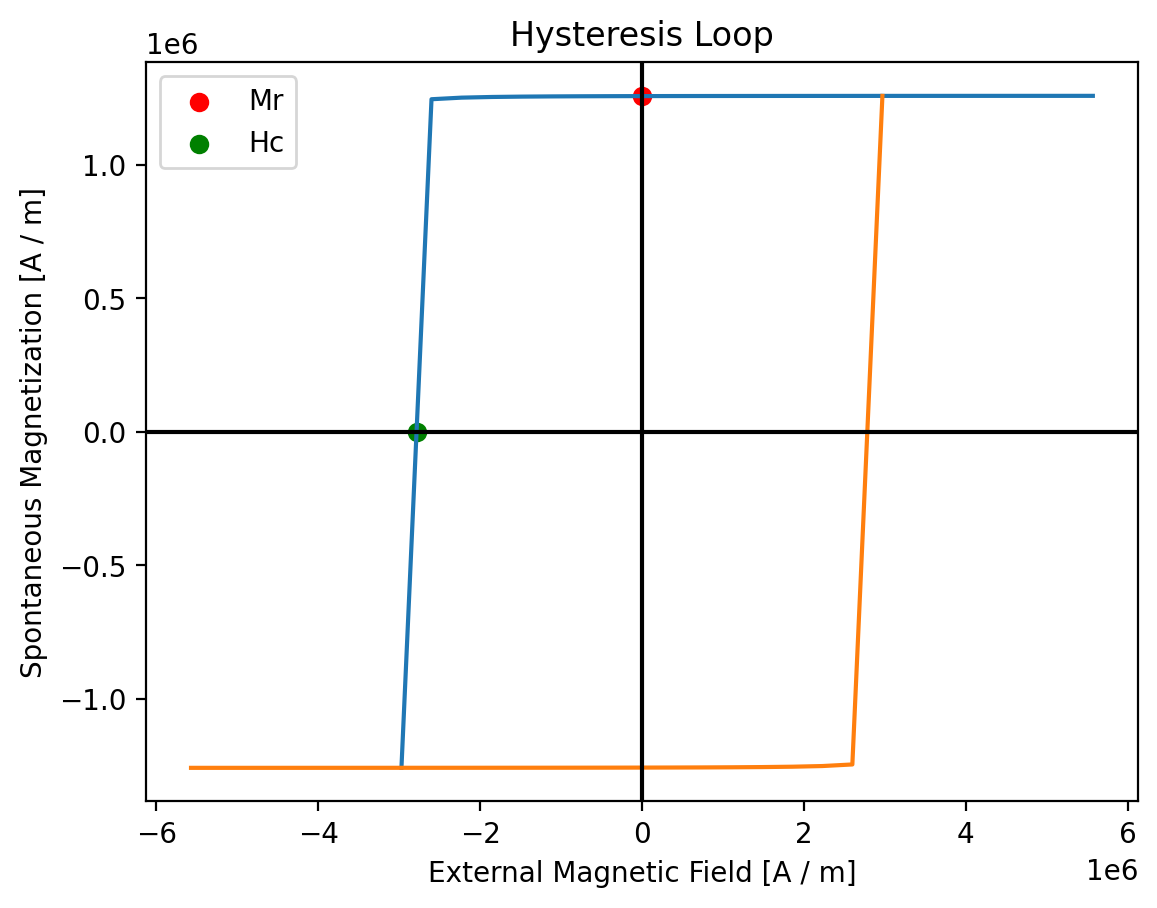

In [33]:
ax = results_hysteresis.plot()
ax.scatter(0, extrinsic_properties.Mr.value, c="r", label="Mr")
ax.scatter(-extrinsic_properties.Hc.value, 0, c="g", label="Hc")
ax.axhline(0, c="k")  # Horizontal line at M=0
ax.axvline(0, c="k")  # Vertical line at H=0
ax.legend();

## Compute Hc(T)

We can leverage mammos to calculate Hc(T) for multiple values of T.

First, we run hysteresis simulations at 7 different temperatures and collect all simulation results:

In [34]:
T = np.linspace(0, 600, 7)

simulations = []
for temperature in T:
    print(f"Running simulation for T={temperature:.0f} K")
    results_hysteresis = mammos_mumag.hysteresis.run(
        mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
        Ms=results_kuzmin.Ms(temperature),
        A=results_kuzmin.A(temperature),
        K1=results_kuzmin.K1(temperature),
        hstart=(7 * u.T).to(u.A / u.m),
        hfinal=(-7 * u.T).to(u.A / u.m),
        hnsteps=30,
    )
    simulations.append(results_hysteresis)

Running simulation for T=0 K
Running simulation for T=100 K
Running simulation for T=200 K
Running simulation for T=300 K
Running simulation for T=400 K
Running simulation for T=500 K
Running simulation for T=600 K


We can now use `mammos_analysis.hysteresis` as shown before to extract Hc for all simulations and visualize Hc(T):

In [35]:
Hcs = []
for res in simulations:
    cf = mammos_analysis.hysteresis.extract_coercive_field(H=res.H, M=res.M).value
    if np.isnan(cf):  # Above Tc
        cf = 0
    Hcs.append(cf)

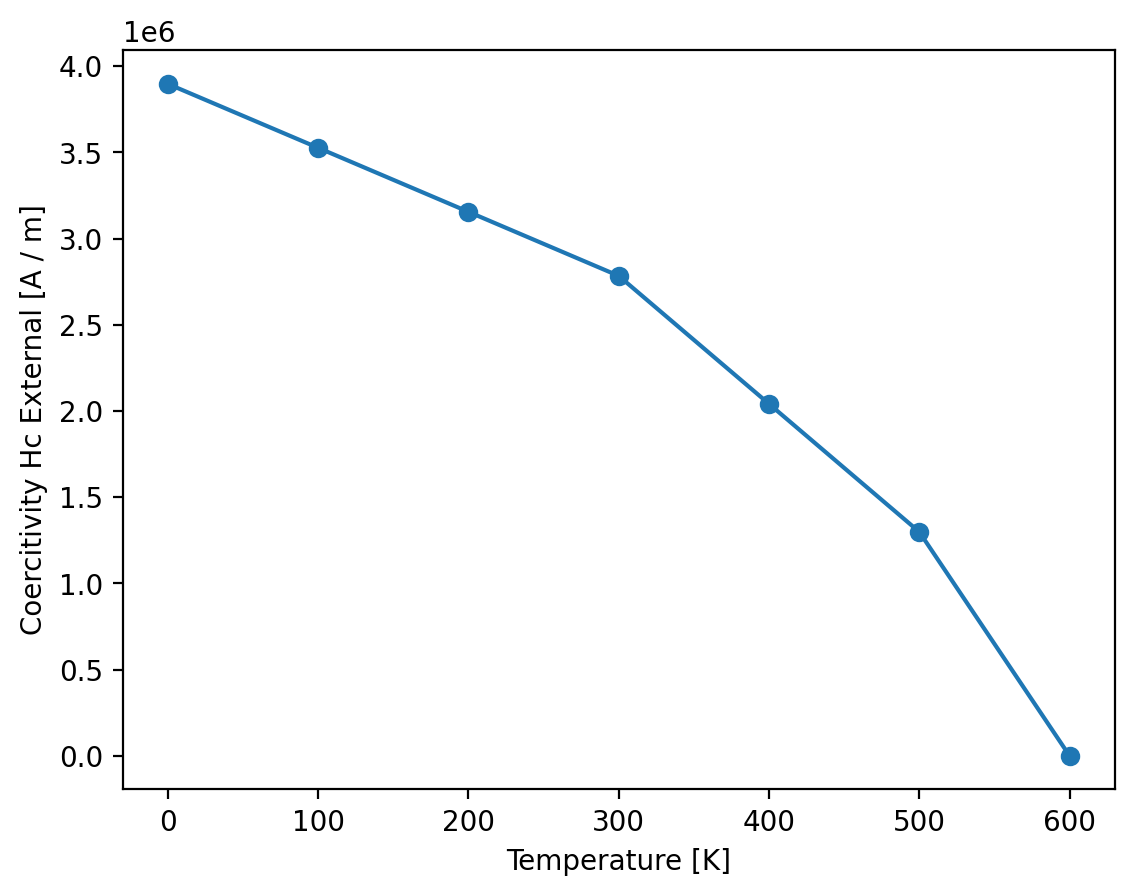

In [36]:
plt.plot(T, Hcs, linestyle="-", marker="o")
plt.xlabel("Temperature [K]")
plt.ylabel("Coercitivity Hc External [A / m]");

We can also show the hysteresis loops of all simulations:

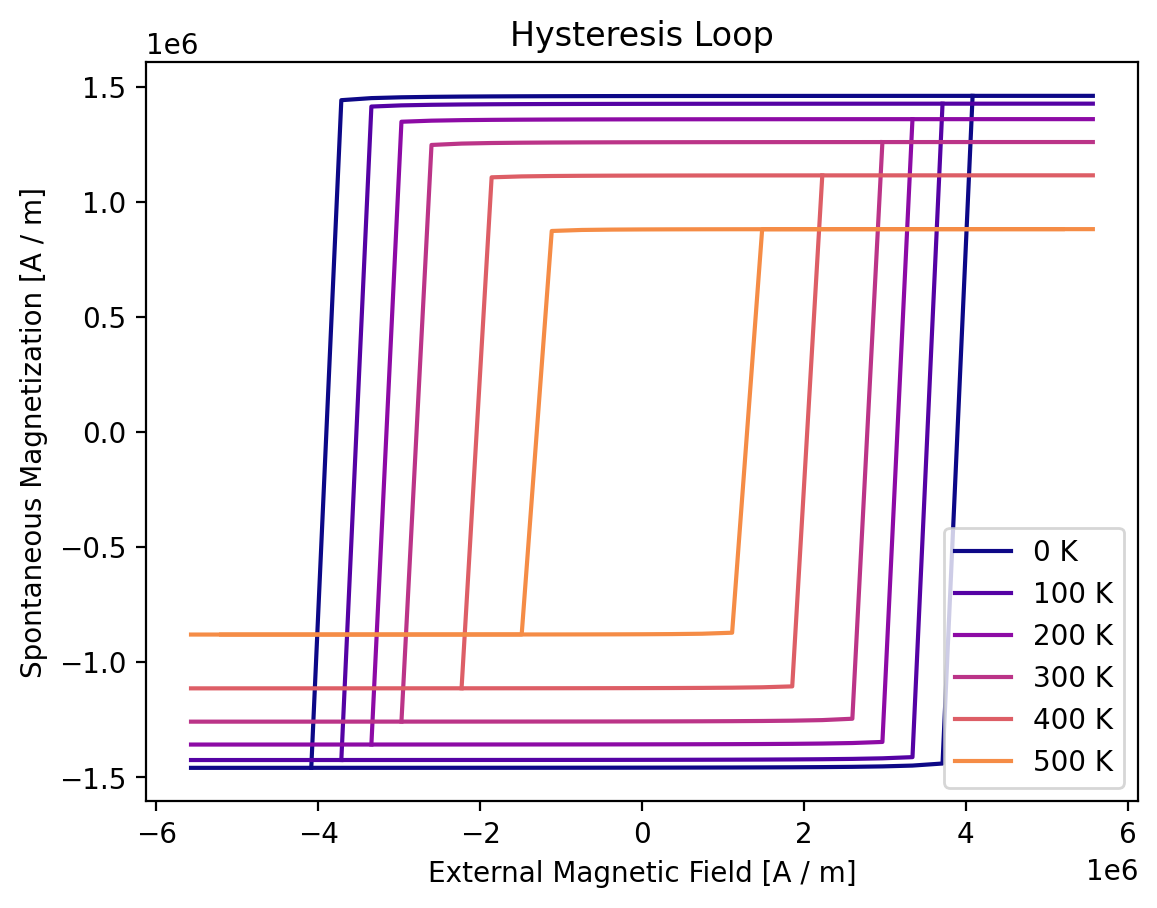

In [37]:
colors = colormaps["plasma"].colors[:: math.ceil(256 / len(T))]

fix, ax = plt.subplots()
for temperature, sim, color in zip(T, simulations, colors):
    if np.isnan(sim.M).all():  # no Ms above Tc
        continue
    sim.plot(ax=ax, label=f"{temperature:.0f} K", color=color, duplicate_change_color=False)
ax.legend(loc="lower right")